In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Load metadata
df = pd.read_csv("sample_metadata.csv")

# Rename columns for clarity (optional)
df.rename(columns={
    'dx': 'diagnosis',
    'localization': 'anatom_site_general_challenge'
}, inplace=True)

# Fill missing values
df['age'] = df['age'].fillna(df['age'].mean())
df['sex'] = df['sex'].fillna('unknown')
df['anatom_site_general_challenge'] = df['anatom_site_general_challenge'].fillna('unknown')

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder
encoders = {}
for col in ['sex', 'anatom_site_general_challenge', 'diagnosis']:
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col])
    encoders[col] = enc

# Split into train/val
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)

print(f"✅ Preprocessed: {len(train_df)} train, {len(val_df)} val samples")


✅ Preprocessed: 1600 train, 400 val samples


In [4]:
import torch.nn as nn
import torchvision.models as models

class HybridNet(nn.Module):
    def __init__(self, num_tabular_features=3, num_classes=7):
        super(HybridNet, self).__init__()
        
        # Image branch (ResNet18 backbone)
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove final layer (we'll fuse manually)
        image_feat_dim = 512  # ResNet18 final feature size
        
        # Tabular branch
        self.tabular_net = nn.Sequential(
            nn.Linear(num_tabular_features, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2)
        )

        # Fusion + Final Classification
        self.classifier = nn.Sequential(
            nn.Linear(image_feat_dim + 32, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, image, tabular):
        image_features = self.cnn(image)            # (batch_size, 512)
        tabular_features = self.tabular_net(tabular)  # (batch_size, 32)
        combined = torch.cat([image_features, tabular_features], dim=1)  # (batch_size, 544)
        out = self.classifier(combined)
        return out


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridNet(num_tabular_features=3, num_classes=len(encoders['diagnosis'].classes_)).to(device)


c:\Users\cheth\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\cheth\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\cheth/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:04<00:00, 10.7MB/s]


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    return (predicted == labels).sum().item() / len(labels)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        train_loss, train_acc = 0, 0
        model.train()
        for images, tabular, labels in train_loader:
            images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)

            outputs = model(images, tabular)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += acc

        val_loss, val_acc = 0, 0
        model.eval()
        with torch.no_grad():
            for images, tabular, labels in val_loader:
                images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)
                outputs = model(images, tabular)
                loss = criterion(outputs, labels)
                acc = accuracy(outputs, labels)

                val_loss += loss.item()
                val_acc += acc

        # Logging
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_acc / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_acc / len(val_loader))

        print(f"📘 Epoch {epoch+1}/{epochs} | Train Acc: {train_acc/len(train_loader):.4f} | Val Acc: {val_acc/len(val_loader):.4f}")
    
    return history


In [10]:
from torch.utils.data import Dataset
from PIL import Image

class SkinLesionDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, row['image_id'] + ".jpg")
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        tabular = torch.tensor([
            row['age'],
            row['sex'],
            row['anatom_site_general_challenge']
        ], dtype=torch.float32)

        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return image, tabular, label


In [11]:
# Create PyTorch Dataset from earlier class
train_dataset = SkinLesionDataset(train_df, "images")
val_dataset = SkinLesionDataset(val_df, "images")

# Create DataLoaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [12]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)


📘 Epoch 1/5 | Train Loss: 1.6050 | Train Acc: 0.5075 | Val Acc: 0.7308
📘 Epoch 2/5 | Train Loss: 1.0218 | Train Acc: 0.7644 | Val Acc: 0.7788
📘 Epoch 3/5 | Train Loss: 0.6285 | Train Acc: 0.8888 | Val Acc: 0.7788
📘 Epoch 4/5 | Train Loss: 0.4385 | Train Acc: 0.9369 | Val Acc: 0.7404
📘 Epoch 5/5 | Train Loss: 0.2997 | Train Acc: 0.9688 | Val Acc: 0.7788


📘 Epoch 1/5 | Train Loss: 0.1919 | Train Acc: 0.9869 | Val Acc: 0.7788
📘 Epoch 2/5 | Train Loss: 0.1279 | Train Acc: 0.9938 | Val Acc: 0.7716
📘 Epoch 3/5 | Train Loss: 0.1011 | Train Acc: 0.9975 | Val Acc: 0.7764
📘 Epoch 4/5 | Train Loss: 0.0805 | Train Acc: 0.9988 | Val Acc: 0.7981
📘 Epoch 5/5 | Train Loss: 0.0701 | Train Acc: 0.9988 | Val Acc: 0.7837


TypeError: 'NoneType' object is not subscriptable

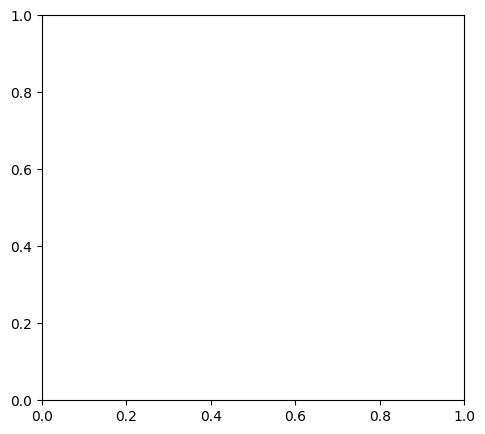

In [13]:
import matplotlib.pyplot as plt

# Run training
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
